In [1]:
import time, os, pickle
import joblib
import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import missingno as msno
import plotly.graph_objects as go
from datetime import datetime
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import RFE


from sklearn.model_selection import KFold, train_test_split,GridSearchCV
from sklearn.preprocessing import MinMaxScaler,MaxAbsScaler,RobustScaler,StandardScaler
from sklearn.feature_selection import VarianceThreshold,mutual_info_classif, f_classif
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import roc_auc_score, mean_squared_error
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import f_classif, mutual_info_classif, VarianceThreshold
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from feature_engine.selection import (
    RecursiveFeatureElimination,
    DropConstantFeatures,
    DropDuplicateFeatures,
)
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from operator import itemgetter
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    classification_report,
    confusion_matrix
)

from sklearn.feature_selection import RFECV


#to ignore warnings
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)  # Allow long lines

In [2]:
# Specify the path to the CSV file in the parent directory
file_path = "../Dataset/pd_speech_features/pd_speech_features.csv"

# Read the CSV file into a DataFrame
df = pd.read_csv(file_path, sep=',',skiprows=1)

In [3]:
df.head()

,id,gender,PPE,DFA,RPDE,numPulses,numPeriodsPulses,meanPeriodPulses,stdDevPeriodPulses,locPctJitter,locAbsJitter,rapJitter,ppq5Jitter,ddpJitter,locShimmer,locDbShimmer,apq3Shimmer,apq5Shimmer,apq11Shimmer,ddaShimmer,meanAutoCorrHarmonicity,meanNoiseToHarmHarmonicity,meanHarmToNoiseHarmonicity,minIntensity,maxIntensity,meanIntensity,f1,f2,f3,f4,b1,b2,b3,b4,GQ_prc5_95,GQ_std_cycle_open,GQ_std_cycle_closed,GNE_mean,GNE_std,GNE_SNR_TKEO,GNE_SNR_SEO,GNE_NSR_TKEO,GNE_NSR_SEO,VFER_mean,VFER_std,VFER_entropy,VFER_SNR_TKEO,VFER_SNR_SEO,VFER_NSR_TKEO,VFER_NSR_SEO,IMF_SNR_SEO,IMF_SNR_TKEO,IMF_SNR_entropy,IMF_NSR_SEO,IMF_NSR_TKEO,IMF_NSR_entropy,mean_Log_energy,mean_MFCC_0th_coef,mean_MFCC_1st_coef,mean_MFCC_2nd_coef,mean_MFCC_3rd_coef,mean_MFCC_4th_coef,mean_MFCC_5th_coef,mean_MFCC_6th_coef,mean_MFCC_7th_coef,mean_MFCC_8th_coef,mean_MFCC_9th_coef,mean_MFCC_10th_coef,mean_MFCC_11th_coef,mean_MFCC_12th_coef,mean_delta_log_energy,mean_0th_delta,mean_1st_delta,mean_2nd_delta,mean_3rd_delta,mean_4th_delta,mean_5th_delta,mean_6th_delta,mean_7th_delta,mean_8th_delta,mean_9th_delta,mean_10th_delta,mean_11th_delta,mean_12th_delta,mean_delta_delta_log_energy,mean_delta_delta_0th,mean_1st_delta_delta,mean_2nd_delta_delta,mean_3rd_delta_delta,mean_4th_delta_delta,mean_5th_delta_delta,mean_6th_delta_delta,mean_7th_delta_delta,mean_8th_delta_delta,mean_9th_delta_delta,mean_10th_delta_delta,mean_11th_delta_delta,mean_12th_delta_delta,std_Log_energy,std_MFCC_0th_coef,std_MFCC_1st_coef,std_MFCC_2nd_coef,std_MFCC_3rd_coef,std_MFCC_4th_coef,std_MFCC_5th_coef,std_MFCC_6th_coef,std_MFCC_7th_coef,std_MFCC_8th_coef,std_MFCC_9th_coef,std_MFCC_10th_coef,std_MFCC_11th_coef,std_MFCC_12th_coef,std_delta_log_energy,std_0th_delta,std_1st_delta,std_2nd_delta,std_3rd_delta,std_4th_delta,std_5th_delta,std_6th_delta,std_7th_delta,std_8th_delta,std_9th_delta,std_10th_delta,std_11th_delta,std_12th_delta,std_delta_delta_log_energy,std_delta_delta_0th,std_1st_delta_delta,std_2nd_delta_delta,std_3rd_delta_delta,std_4th_delta_delta,std_5th_delta_delta,std_6th_delta_delta,std_7th_delta_delta,std_8th_delta_delta,std_9th_delta_delta,std_10th_delta_delta,std_11th_delta_delta,std_12th_delta_delta,Ea,Ed_1_coef,Ed_2_coef,Ed_3_coef,Ed_4_coef,Ed_5_coef,Ed_6_coef,Ed_7_coef,Ed_8_coef,Ed_9_coef,Ed_10_coef,det_entropy_shannon_1_coef,det_entropy_shannon_2_coef,det_entropy_shannon_3_coef,det_entropy_shannon_4_coef,det_entropy_shannon_5_coef,det_entropy_shannon_6_coef,det_entropy_shannon_7_coef,det_entropy_shannon_8_coef,det_entropy_shannon_9_coef,det_entropy_shannon_10_coef,det_entropy_log_1_coef,det_entropy_log_2_coef,det_entropy_log_3_coef,det_entropy_log_4_coef,det_entropy_log_5_coef,det_entropy_log_6_coef,det_entropy_log_7_coef,det_entropy_log_8_coef,det_entropy_log_9_coef,det_entropy_log_10_coef,det_TKEO_mean_1_coef,det_TKEO_mean_2_coef,det_TKEO_mean_3_coef,det_TKEO_mean_4_coef,det_TKEO_mean_5_coef,det_TKEO_mean_6_coef,det_TKEO_mean_7_coef,det_TKEO_mean_8_coef,det_TKEO_mean_9_coef,det_TKEO_mean_10_coef,det_TKEO_std_1_coef,det_TKEO_std_2_coef,det_TKEO_std_3_coef,det_TKEO_std_4_coef,det_TKEO_std_5_coef,det_TKEO_std_6_coef,det_TKEO_std_7_coef,det_TKEO_std_8_coef,det_TKEO_std_9_coef,det_TKEO_std_10_coef,app_entropy_shannon_1_coef,app_entropy_shannon_2_coef,app_entropy_shannon_3_coef,app_entropy_shannon_4_coef,app_entropy_shannon_5_coef,app_entropy_shannon_6_coef,app_entropy_shannon_7_coef,app_entropy_shannon_8_coef,app_entropy_shannon_9_coef,app_entropy_shannon_10_coef,app_entropy_log_1_coef,app_entropy_log_2_coef,app_entropy_log_3_coef,app_entropy_log_4_coef,app_entropy_log_5_coef,app_entropy_log_6_coef,app_entropy_log_7_coef,app_entropy_log_8_coef,app_entropy_log_9_coef,app_entropy_log_10_coef,app_det_TKEO_mean_1_coef,app_det_TKEO_mean_2_coef,app_det_TKEO_mean_3_coef,app_det_TKEO_mean_4_coef,app_det_TKEO_mean_5_coef,app_det_TKEO_mean_6_coef,app_det_TKEO_mean_7_coef,app_det_TKEO_mean_8_coef,app_det_TKEO_mean_9_coef,app_det_TKEO_mean_10_coef,app_TKEO_std_1_coef,app_TKEO_std_2_coef,app_TKEO_

# Filtrar o Dataset para apenas apresentar dados do Sexo Feminino e sexo Masculino

In [4]:
female_df = df[df['gender'] == 0]
male_df = df[df['gender'] == 1]
female_df.shape
male_df.shape

(390, 755)

# Drop da Coluna de Id

In [5]:
female_df = female_df.drop("id", axis=1)
male_df = male_df.drop("id", axis=1)

# Divisão entre features e label

In [6]:
X_female = female_df.drop('class', axis=1)  # Features
y_female = female_df['class']  # Target variable
X_male = male_df.drop('class', axis=1)  # Features
y_male = male_df['class']  # Target variable

# SMOTE

In [7]:
smote_female = SMOTE(sampling_strategy='auto', random_state=42)
X_female_smote, y_female_smote = smote_female.fit_resample(X_female, y_female)

smote_male = SMOTE(sampling_strategy='auto', random_state=42)
X_male_smote, y_male_smote = smote_male.fit_resample(X_male, y_male)

In [8]:
unique, counts = np.unique(y_female, return_counts=True)
original_class_distribution = dict(zip(unique, counts))
unique, counts = np.unique(y_female_smote, return_counts=True)
resampled_class_distribution = dict(zip(unique, counts))

print("Original class distribution:", original_class_distribution)
print("Resampled class distribution:", resampled_class_distribution)

Original class distribution: {0: 123, 1: 243}
Resampled class distribution: {0: 243, 1: 243}


In [9]:
unique, counts = np.unique(y_male, return_counts=True)
original_class_distribution = dict(zip(unique, counts))
unique, counts = np.unique(y_male_smote, return_counts=True)
resampled_class_distribution = dict(zip(unique, counts))

print("Original class distribution:", original_class_distribution)
print("Resampled class distribution:", resampled_class_distribution)

Original class distribution: {0: 69, 1: 321}
Resampled class distribution: {0: 321, 1: 321}


# Normalização dos dois Datasets (Feminino e Masculino)

In [10]:
features = X_female_smote.columns

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Scale the features
X_female_smote_scaled = pd.DataFrame(scaler.fit_transform(X_female_smote[features]), columns=features)

In [11]:
features = X_male_smote.columns

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Scale the features
X_male_smote_scaled = pd.DataFrame(scaler.fit_transform(X_male_smote[features]), columns=features)

# Correlation

In [12]:
# with the following function we can select highly correlated features
# it will remove the first feature that is correlated with anything else
# without any further insight.

def correlation(dataset, threshold):
    
    # create a set where I will store the names of correlated columns
    col_corr = set()
    
    # create the correlation matrix
    corr_matrix = dataset.corr()
    
    # for each feature in the dataset (columns of the correlation matrix)
    for i in range(len(corr_matrix.columns)):
        
        # check with other features
        for j in range(i):
            
            # if the correlation is higher than a certain threshold
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                
                # print correlation, and variables examined
                # keep in mind that the columns and rows of the dataframe are identical
                # so we can identify the features being examned by looking for i,j
                # in the column names
                print(abs(corr_matrix.iloc[i, j]), corr_matrix.columns[i], corr_matrix.columns[j])
                
                # get the name of the correlated feature
                colname = corr_matrix.columns[j]
                
                # and add it to our correlated set
                col_corr.add(colname)
                
    return col_corr

In [13]:
corr_features_female = correlation(X_female_smote_scaled, 0.8)
corr_features_male = correlation(X_male_smote_scaled, 0.8)
print(len(set(corr_features_female)))
print(len(set(corr_features_male)))

0.9999460815644424 numPeriodsPulses numPulses
0.9027891354450992 meanPeriodPulses numPulses
0.9026458394763934 meanPeriodPulses numPeriodsPulses
0.9561477902685724 locAbsJitter locPctJitter
0.9587158530168505 rapJitter locPctJitter
0.9625658640253487 rapJitter locAbsJitter
0.9660429384212299 ppq5Jitter locPctJitter
0.951454143205803 ppq5Jitter locAbsJitter
0.9699975826011277 ppq5Jitter rapJitter
0.9587320691814611 ddpJitter locPctJitter
0.9626363370250992 ddpJitter locAbsJitter
0.9999941872028469 ddpJitter rapJitter
0.9700416050994086 ddpJitter ppq5Jitter
0.9959380227759249 locDbShimmer locShimmer
0.982907590008753 apq3Shimmer locShimmer
0.9767030438081709 apq3Shimmer locDbShimmer
0.9841284841711554 apq5Shimmer locShimmer
0.9773652427312904 apq5Shimmer locDbShimmer
0.9675872869069989 apq5Shimmer apq3Shimmer
0.9145265491337877 apq11Shimmer locShimmer
0.9156226070834663 apq11Shimmer locDbShimmer
0.8663046155327179 apq11Shimmer apq3Shimmer
0.9285285880029288 apq11Shimmer apq5Shimmer
0.982

0.901033714655325 app_entropy_log_5_coef app_entropy_shannon_1_coef
0.9050418453327737 app_entropy_log_5_coef app_entropy_shannon_2_coef
0.9087942833899694 app_entropy_log_5_coef app_entropy_shannon_3_coef
0.912006886477047 app_entropy_log_5_coef app_entropy_shannon_4_coef
0.9138814855136755 app_entropy_log_5_coef app_entropy_shannon_5_coef
0.9139344732708254 app_entropy_log_5_coef app_entropy_shannon_6_coef
0.9147799598587586 app_entropy_log_5_coef app_entropy_shannon_7_coef
0.9143909339590964 app_entropy_log_5_coef app_entropy_shannon_8_coef
0.9146981976200775 app_entropy_log_5_coef app_entropy_shannon_9_coef
0.9151036758420183 app_entropy_log_5_coef app_entropy_shannon_10_coef
0.940951127202591 app_entropy_log_5_coef app_entropy_log_1_coef
0.9522615446822914 app_entropy_log_5_coef app_entropy_log_2_coef
0.9710330217243076 app_entropy_log_5_coef app_entropy_log_3_coef
0.9937399681172395 app_entropy_log_5_coef app_entropy_log_4_coef
0.8531393133351997 app_entropy_log_6_coef numPulses


0.9014511879037697 det_LT_entropy_log_2_coef det_entropy_log_1_coef
0.9730444279367878 det_LT_entropy_log_2_coef det_entropy_log_2_coef
0.8970174967227241 det_LT_entropy_log_2_coef det_entropy_log_3_coef
0.8191682969790426 det_LT_entropy_log_2_coef det_entropy_log_4_coef
0.8204587943803934 det_LT_entropy_log_2_coef det_LT_entropy_shannon_1_coef
0.8473199500739174 det_LT_entropy_log_2_coef det_LT_entropy_shannon_2_coef
0.8397816224933015 det_LT_entropy_log_2_coef det_LT_entropy_shannon_3_coef
0.9504099375590916 det_LT_entropy_log_2_coef det_LT_entropy_log_1_coef
0.8595623875066807 det_LT_entropy_log_3_coef det_entropy_log_2_coef
0.9748548849319292 det_LT_entropy_log_3_coef det_entropy_log_3_coef
0.8353607067123768 det_LT_entropy_log_3_coef det_entropy_log_4_coef
0.8042997426044595 det_LT_entropy_log_3_coef det_LT_entropy_shannon_2_coef
0.8287837423131054 det_LT_entropy_log_3_coef det_LT_entropy_shannon_3_coef
0.8522887371426677 det_LT_entropy_log_3_coef det_LT_entropy_log_1_coef
0.91099

0.9449527505690554 app_LT_entropy_shannon_8_coef app_LT_entropy_shannon_1_coef
0.9563224777705959 app_LT_entropy_shannon_8_coef app_LT_entropy_shannon_2_coef
0.9708174174255074 app_LT_entropy_shannon_8_coef app_LT_entropy_shannon_3_coef
0.9863350588835208 app_LT_entropy_shannon_8_coef app_LT_entropy_shannon_4_coef
0.994989009713192 app_LT_entropy_shannon_8_coef app_LT_entropy_shannon_5_coef
0.9989496521273751 app_LT_entropy_shannon_8_coef app_LT_entropy_shannon_6_coef
0.9992025651393253 app_LT_entropy_shannon_8_coef app_LT_entropy_shannon_7_coef
0.8492698285757735 app_LT_entropy_shannon_9_coef numPulses
0.8494972508687278 app_LT_entropy_shannon_9_coef numPeriodsPulses
0.9036016932311396 app_LT_entropy_shannon_9_coef app_entropy_shannon_1_coef
0.909946574018473 app_LT_entropy_shannon_9_coef app_entropy_shannon_2_coef
0.916900294828202 app_LT_entropy_shannon_9_coef app_entropy_shannon_3_coef
0.9246470739772126 app_LT_entropy_shannon_9_coef app_entropy_shannon_4_coef
0.9302153956889473 ap

0.9837701583535134 app_LT_TKEO_std_7_coef app_entropy_log_9_coef
0.9836046079213289 app_LT_TKEO_std_7_coef app_entropy_log_10_coef
0.8558735395523761 app_LT_TKEO_std_7_coef app_det_TKEO_mean_3_coef
0.9234420435842056 app_LT_TKEO_std_7_coef app_det_TKEO_mean_4_coef
0.9371926074374708 app_LT_TKEO_std_7_coef app_det_TKEO_mean_5_coef
0.9408180672637071 app_LT_TKEO_std_7_coef app_det_TKEO_mean_6_coef
0.9425833623168369 app_LT_TKEO_std_7_coef app_det_TKEO_mean_7_coef
0.9435391816708218 app_LT_TKEO_std_7_coef app_det_TKEO_mean_8_coef
0.9434892445074365 app_LT_TKEO_std_7_coef app_det_TKEO_mean_9_coef
0.9451211850452218 app_LT_TKEO_std_7_coef app_det_TKEO_mean_10_coef
0.8284923816809289 app_LT_TKEO_std_7_coef app_TKEO_std_3_coef
0.8957755042853811 app_LT_TKEO_std_7_coef app_TKEO_std_4_coef
0.9264766256952357 app_LT_TKEO_std_7_coef app_TKEO_std_5_coef
0.9312000820629508 app_LT_TKEO_std_7_coef app_TKEO_std_6_coef
0.9385848479856894 app_LT_TKEO_std_7_coef app_TKEO_std_7_coef
0.9397786932534135 app

0.821882251097296 tqwt_entropy_shannon_dec_2 tqwt_entropy_shannon_dec_1
0.89182017905081 tqwt_entropy_shannon_dec_3 tqwt_entropy_shannon_dec_2
0.8288680870791384 tqwt_entropy_shannon_dec_4 tqwt_entropy_shannon_dec_3
0.8833226880882533 tqwt_entropy_shannon_dec_5 tqwt_entropy_shannon_dec_4
0.8018451688382889 tqwt_entropy_shannon_dec_6 tqwt_entropy_shannon_dec_5
0.8705404585573376 tqwt_entropy_shannon_dec_8 tqwt_energy_dec_8
0.8887862349943906 tqwt_entropy_shannon_dec_8 tqwt_entropy_shannon_dec_7
0.8087264717873432 tqwt_entropy_shannon_dec_9 tqwt_energy_dec_9
0.8772351468557136 tqwt_entropy_shannon_dec_9 tqwt_entropy_shannon_dec_8
0.8323887752546104 tqwt_entropy_shannon_dec_10 tqwt_energy_dec_10
0.8412317718166396 tqwt_entropy_shannon_dec_10 tqwt_entropy_shannon_dec_9
0.8111382856800762 tqwt_entropy_shannon_dec_11 tqwt_energy_dec_11
0.8101049395032246 tqwt_entropy_shannon_dec_11 tqwt_energy_dec_12
0.8099139040174226 tqwt_entropy_shannon_dec_11 tqwt_entropy_shannon_dec_10
0.831442342138515

0.803554149216556 tqwt_entropy_log_dec_28 tqwt_entropy_log_dec_27
0.8933912584703657 tqwt_entropy_log_dec_29 tqwt_entropy_log_dec_28
0.859674880673663 tqwt_entropy_log_dec_30 tqwt_entropy_log_dec_29
0.9554622069814729 tqwt_entropy_log_dec_31 tqwt_entropy_log_dec_30
0.8786595011423649 tqwt_entropy_log_dec_32 tqwt_entropy_log_dec_30
0.9655551693889617 tqwt_entropy_log_dec_32 tqwt_entropy_log_dec_31
0.8218897487353666 tqwt_entropy_log_dec_33 tqwt_entropy_log_dec_30
0.9011085092097147 tqwt_entropy_log_dec_33 tqwt_entropy_log_dec_31
0.956941772941486 tqwt_entropy_log_dec_33 tqwt_entropy_log_dec_32
0.9017641958681821 tqwt_entropy_log_dec_34 tqwt_entropy_log_dec_33
0.8406261496136657 tqwt_entropy_log_dec_35 tqwt_entropy_log_dec_33
0.980818424347645 tqwt_entropy_log_dec_35 tqwt_entropy_log_dec_34
0.8051697832029212 tqwt_entropy_log_dec_36 tqwt_entropy_log_dec_34
0.8303492837455021 tqwt_entropy_log_dec_36 tqwt_entropy_log_dec_35
0.986515941649851 tqwt_TKEO_mean_dec_1 tqwt_entropy_shannon_dec_1


0.9932865284600808 tqwt_TKEO_std_dec_31 tqwt_TKEO_mean_dec_31
0.9671387334461787 tqwt_TKEO_std_dec_32 det_LT_entropy_shannon_6_coef
0.8249834008898078 tqwt_TKEO_std_dec_32 det_LT_TKEO_std_6_coef
0.9726461718731162 tqwt_TKEO_std_dec_32 tqwt_energy_dec_32
0.9749433256592127 tqwt_TKEO_std_dec_32 tqwt_energy_dec_33
0.9643218408496826 tqwt_TKEO_std_dec_32 tqwt_entropy_shannon_dec_32
0.9673996055109821 tqwt_TKEO_std_dec_32 tqwt_entropy_shannon_dec_33
0.9996173416018296 tqwt_TKEO_std_dec_32 tqwt_TKEO_mean_dec_32
0.9969989632341155 tqwt_TKEO_std_dec_32 tqwt_TKEO_mean_dec_33
0.9540789507094254 tqwt_TKEO_std_dec_33 det_LT_entropy_shannon_6_coef
0.8089586802435307 tqwt_TKEO_std_dec_33 det_LT_TKEO_std_6_coef
0.9740483685142366 tqwt_TKEO_std_dec_33 tqwt_energy_dec_32
0.9829786836012271 tqwt_TKEO_std_dec_33 tqwt_energy_dec_33
0.9555178999440173 tqwt_TKEO_std_dec_33 tqwt_entropy_shannon_dec_32
0.9549751841151938 tqwt_TKEO_std_dec_33 tqwt_entropy_shannon_dec_33
0.995756159998487 tqwt_TKEO_std_dec_33 t

0.8693655451865343 tqwt_stdValue_dec_15 tqwt_entropy_log_dec_15
0.8168578662511587 tqwt_stdValue_dec_15 tqwt_entropy_log_dec_16
0.9319083086246955 tqwt_stdValue_dec_15 tqwt_TKEO_mean_dec_15
0.8749562959312848 tqwt_stdValue_dec_15 tqwt_TKEO_mean_dec_16
0.8067343745942119 tqwt_stdValue_dec_15 tqwt_TKEO_std_dec_14
0.9329804856601741 tqwt_stdValue_dec_15 tqwt_TKEO_std_dec_15
0.9114997695017344 tqwt_stdValue_dec_15 tqwt_TKEO_std_dec_16
0.9247206096608551 tqwt_stdValue_dec_15 tqwt_stdValue_dec_14
0.8275336901179439 tqwt_stdValue_dec_16 tqwt_energy_dec_16
0.8224119658481218 tqwt_stdValue_dec_16 tqwt_entropy_shannon_dec_14
0.9244327439632857 tqwt_stdValue_dec_16 tqwt_entropy_shannon_dec_15
0.9761292940093281 tqwt_stdValue_dec_16 tqwt_entropy_shannon_dec_16
0.804689206684694 tqwt_stdValue_dec_16 tqwt_entropy_log_dec_13
0.8164705689880933 tqwt_stdValue_dec_16 tqwt_entropy_log_dec_14
0.857682115399656 tqwt_stdValue_dec_16 tqwt_entropy_log_dec_15
0.8743302306439434 tqwt_stdValue_dec_16 tqwt_entrop

0.8311314635559416 tqwt_minValue_dec_18 tqwt_entropy_log_dec_18
0.8496503040552873 tqwt_minValue_dec_18 tqwt_TKEO_mean_dec_18
0.911709223464416 tqwt_minValue_dec_18 tqwt_TKEO_std_dec_18
0.9455951724045001 tqwt_minValue_dec_18 tqwt_stdValue_dec_18
0.8060088480763477 tqwt_minValue_dec_18 tqwt_stdValue_dec_19
0.8502644070538368 tqwt_minValue_dec_18 tqwt_minValue_dec_17
0.9016919371854182 tqwt_minValue_dec_19 tqwt_entropy_shannon_dec_19
0.8309498776609606 tqwt_minValue_dec_19 tqwt_entropy_shannon_dec_20
0.804427179723724 tqwt_minValue_dec_19 tqwt_entropy_log_dec_19
0.8161298897181704 tqwt_minValue_dec_19 tqwt_TKEO_mean_dec_19
0.9204236468323443 tqwt_minValue_dec_19 tqwt_TKEO_std_dec_19
0.9346609141480136 tqwt_minValue_dec_19 tqwt_stdValue_dec_19
0.8478103366041252 tqwt_minValue_dec_19 tqwt_stdValue_dec_20
0.8449070448510979 tqwt_minValue_dec_19 tqwt_minValue_dec_18
0.8941676785800657 tqwt_minValue_dec_20 tqwt_entropy_shannon_dec_20
0.8255893365487833 tqwt_minValue_dec_20 tqwt_TKEO_mean_dec

0.9691000171067256 tqwt_maxValue_dec_25 tqwt_stdValue_dec_25
0.9968362303601987 tqwt_maxValue_dec_25 tqwt_minValue_dec_25
0.8242309988362001 tqwt_maxValue_dec_25 tqwt_minValue_dec_26
0.8355189662036206 tqwt_maxValue_dec_26 tqwt_TKEO_mean_dec_26
0.8186743383086672 tqwt_maxValue_dec_26 tqwt_TKEO_std_dec_26
0.9337230551591246 tqwt_maxValue_dec_26 tqwt_stdValue_dec_26
0.8227159776040418 tqwt_maxValue_dec_26 tqwt_minValue_dec_25
0.9945129108128531 tqwt_maxValue_dec_26 tqwt_minValue_dec_26
0.8147017623469363 tqwt_maxValue_dec_26 tqwt_maxValue_dec_25
0.8822056973286135 tqwt_maxValue_dec_27 tqwt_TKEO_std_dec_27
0.9148876555759471 tqwt_maxValue_dec_27 tqwt_stdValue_dec_27
0.9710890973492895 tqwt_maxValue_dec_27 tqwt_minValue_dec_27
0.81234619423492 tqwt_maxValue_dec_28 tqwt_TKEO_mean_dec_28
0.9226663449343823 tqwt_maxValue_dec_28 tqwt_stdValue_dec_28
0.8239475156624366 tqwt_maxValue_dec_28 tqwt_stdValue_dec_29
0.9763561621327331 tqwt_maxValue_dec_28 tqwt_minValue_dec_28
0.8656872265547427 tqwt_

0.8026527140842905 tqwt_kurtosisValue_dec_28 tqwt_kurtosisValue_dec_27
0.9318934034966009 tqwt_kurtosisValue_dec_29 tqwt_kurtosisValue_dec_28
0.8613183232718532 tqwt_kurtosisValue_dec_30 tqwt_kurtosisValue_dec_29
0.9107747821024479 tqwt_kurtosisValue_dec_31 tqwt_kurtosisValue_dec_30
0.9013003766399197 tqwt_kurtosisValue_dec_32 tqwt_kurtosisValue_dec_31
0.927495871056495 tqwt_kurtosisValue_dec_33 tqwt_kurtosisValue_dec_32
0.8243271324249933 tqwt_kurtosisValue_dec_34 tqwt_kurtosisValue_dec_33
0.926800179114759 tqwt_kurtosisValue_dec_35 tqwt_kurtosisValue_dec_34
0.8272300946261333 tqwt_kurtosisValue_dec_36 tqwt_kurtosisValue_dec_35
0.9998709722684271 numPeriodsPulses numPulses
0.8318404449804992 meanPeriodPulses numPulses
0.8313787456101608 meanPeriodPulses numPeriodsPulses
0.9653667585114205 locAbsJitter locPctJitter
0.9638729891264443 rapJitter locPctJitter
0.9449643908609358 rapJitter locAbsJitter
0.9530844275122237 ppq5Jitter locPctJitter
0.9406626459053924 ppq5Jitter locAbsJitter
0.9

0.9988101273569038 app_entropy_log_2_coef app_entropy_log_1_coef
0.9918764840268663 app_entropy_log_3_coef app_entropy_log_1_coef
0.9962228757999383 app_entropy_log_3_coef app_entropy_log_2_coef
0.9569177319673052 app_entropy_log_4_coef app_entropy_log_1_coef
0.9685515713769929 app_entropy_log_4_coef app_entropy_log_2_coef
0.9851988476073259 app_entropy_log_4_coef app_entropy_log_3_coef
0.8404683905113433 app_entropy_log_5_coef numPulses
0.8427595889919309 app_entropy_log_5_coef numPeriodsPulses
0.8701854309577058 app_entropy_log_5_coef app_entropy_log_1_coef
0.8905476615258541 app_entropy_log_5_coef app_entropy_log_2_coef
0.9240013029007323 app_entropy_log_5_coef app_entropy_log_3_coef
0.9751708873983214 app_entropy_log_5_coef app_entropy_log_4_coef
0.845728291595674 app_entropy_log_6_coef numPulses
0.8481937649616903 app_entropy_log_6_coef numPeriodsPulses
0.8019755747688025 app_entropy_log_6_coef app_entropy_shannon_5_coef
0.8051225292739431 app_entropy_log_6_coef app_entropy_shanno

0.9816872280863495 Ed2_1_coef det_TKEO_mean_1_coef
0.9075440994158208 Ed2_1_coef det_TKEO_mean_2_coef
0.8190012643387072 Ed2_1_coef det_TKEO_mean_3_coef
0.8350592026392231 Ed2_1_coef det_TKEO_mean_5_coef
0.8980636135433248 Ed2_1_coef det_TKEO_std_1_coef
0.8780309022473637 Ed2_1_coef det_TKEO_std_2_coef
0.8181821162404225 Ed2_1_coef det_TKEO_std_5_coef
0.8442401999669688 Ed2_2_coef Ed_1_coef
0.9675326176320059 Ed2_2_coef Ed_2_coef
0.9653515056367341 Ed2_2_coef Ed_3_coef
0.9187025152631395 Ed2_2_coef Ed_5_coef
0.8053581521646965 Ed2_2_coef Ed_6_coef
0.8864881489511508 Ed2_2_coef det_entropy_shannon_1_coef
0.9744064978031199 Ed2_2_coef det_entropy_shannon_2_coef
0.9445560524395727 Ed2_2_coef det_entropy_shannon_3_coef
0.9174742509785776 Ed2_2_coef det_entropy_shannon_5_coef
0.9140788505193599 Ed2_2_coef det_TKEO_mean_1_coef
0.9669853085686396 Ed2_2_coef det_TKEO_mean_2_coef
0.9486563007049651 Ed2_2_coef det_TKEO_mean_3_coef
0.9133143144683796 Ed2_2_coef det_TKEO_mean_5_coef
0.927915206505

0.9093227065142152 det_LT_TKEO_mean_2_coef Ed_3_coef
0.8658577132338113 det_LT_TKEO_mean_2_coef Ed_5_coef
0.872832127279278 det_LT_TKEO_mean_2_coef det_entropy_shannon_1_coef
0.9553691524132619 det_LT_TKEO_mean_2_coef det_entropy_shannon_2_coef
0.9136637851394518 det_LT_TKEO_mean_2_coef det_entropy_shannon_3_coef
0.8835442509942194 det_LT_TKEO_mean_2_coef det_entropy_shannon_5_coef
0.9026227434655723 det_LT_TKEO_mean_2_coef det_TKEO_mean_1_coef
0.9617698619268991 det_LT_TKEO_mean_2_coef det_TKEO_mean_2_coef
0.9123618441875538 det_LT_TKEO_mean_2_coef det_TKEO_mean_3_coef
0.8887253939141139 det_LT_TKEO_mean_2_coef det_TKEO_mean_5_coef
0.9455645432134689 det_LT_TKEO_mean_2_coef det_TKEO_std_2_coef
0.8904389378100102 det_LT_TKEO_mean_2_coef det_TKEO_std_3_coef
0.8663418125821442 det_LT_TKEO_mean_2_coef det_TKEO_std_5_coef
0.8738723933876953 det_LT_TKEO_mean_2_coef app_det_TKEO_mean_1_coef
0.8933811706770931 det_LT_TKEO_mean_2_coef Ed2_1_coef
0.9823357815917435 det_LT_TKEO_mean_2_coef Ed2_2

0.8087572539007133 app_LT_entropy_shannon_8_coef app_entropy_shannon_4_coef
0.8209774813483774 app_LT_entropy_shannon_8_coef app_entropy_shannon_5_coef
0.8294156826062486 app_LT_entropy_shannon_8_coef app_entropy_shannon_6_coef
0.832444590995506 app_LT_entropy_shannon_8_coef app_entropy_shannon_7_coef
0.8361376176903341 app_LT_entropy_shannon_8_coef app_entropy_shannon_8_coef
0.8367841844116726 app_LT_entropy_shannon_8_coef app_entropy_shannon_9_coef
0.8374276055107941 app_LT_entropy_shannon_8_coef app_entropy_shannon_10_coef
0.8642294709817767 app_LT_entropy_shannon_8_coef app_entropy_log_5_coef
0.9442533139915902 app_LT_entropy_shannon_8_coef app_entropy_log_6_coef
0.9503157029735865 app_LT_entropy_shannon_8_coef app_entropy_log_7_coef
0.9927639486010642 app_LT_entropy_shannon_8_coef app_entropy_log_8_coef
0.9927474040605506 app_LT_entropy_shannon_8_coef app_entropy_log_9_coef
0.9927201858464576 app_LT_entropy_shannon_8_coef app_entropy_log_10_coef
0.8092025024428648 app_LT_entropy_s

0.8862777172371648 app_LT_TKEO_std_2_coef app_entropy_log_8_coef
0.8864496658884997 app_LT_TKEO_std_2_coef app_entropy_log_9_coef
0.886570188231574 app_LT_TKEO_std_2_coef app_entropy_log_10_coef
0.8308640117726002 app_LT_TKEO_std_2_coef app_det_TKEO_mean_3_coef
0.8455593412735501 app_LT_TKEO_std_2_coef app_det_TKEO_mean_4_coef
0.8262129598462473 app_LT_TKEO_std_2_coef app_det_TKEO_mean_5_coef
0.8173485086281507 app_LT_TKEO_std_2_coef app_det_TKEO_mean_6_coef
0.8143250468736571 app_LT_TKEO_std_2_coef app_det_TKEO_mean_7_coef
0.8378246795039179 app_LT_TKEO_std_2_coef app_TKEO_std_4_coef
0.8286720646945226 app_LT_TKEO_std_2_coef app_TKEO_std_5_coef
0.8186962509558922 app_LT_TKEO_std_2_coef app_TKEO_std_6_coef
0.8113657825822838 app_LT_TKEO_std_2_coef app_TKEO_std_8_coef
0.8226050586155612 app_LT_TKEO_std_2_coef app_LT_entropy_shannon_6_coef
0.8286236976881861 app_LT_TKEO_std_2_coef app_LT_entropy_shannon_7_coef
0.8524335361664808 app_LT_TKEO_std_2_coef app_LT_entropy_shannon_8_coef
0.8523

0.844372951970173 tqwt_energy_dec_30 tqwt_energy_dec_29
0.945003598103242 tqwt_energy_dec_32 tqwt_energy_dec_31
0.9062560414524452 tqwt_energy_dec_33 tqwt_energy_dec_31
0.9928409324862654 tqwt_energy_dec_33 tqwt_energy_dec_32
0.9151487416823865 tqwt_energy_dec_34 tqwt_energy_dec_31
0.9856259180747812 tqwt_energy_dec_34 tqwt_energy_dec_32
0.9851297467358738 tqwt_energy_dec_34 tqwt_energy_dec_33
0.8010122853641392 tqwt_energy_dec_35 Ed2_2_coef
0.8221039700297705 tqwt_energy_dec_35 det_LT_TKEO_mean_2_coef
0.8292931461603859 tqwt_energy_dec_35 det_LT_TKEO_std_2_coef
0.8055618252426753 tqwt_energy_dec_36 det_LT_TKEO_mean_2_coef
0.8125344242826035 tqwt_energy_dec_36 det_LT_TKEO_std_2_coef
0.9399895413985477 tqwt_energy_dec_36 tqwt_energy_dec_35
0.9265214546149677 tqwt_entropy_shannon_dec_2 tqwt_entropy_shannon_dec_1
0.8088264575702488 tqwt_entropy_shannon_dec_3 tqwt_entropy_shannon_dec_1
0.9410350922155792 tqwt_entropy_shannon_dec_3 tqwt_entropy_shannon_dec_2
0.8112185781058144 tqwt_entropy_

0.9842082097350383 tqwt_TKEO_mean_dec_1 tqwt_entropy_shannon_dec_1
0.8980153038185338 tqwt_TKEO_mean_dec_1 tqwt_entropy_shannon_dec_2
0.9254124210861137 tqwt_TKEO_mean_dec_2 tqwt_entropy_shannon_dec_1
0.9874622082951618 tqwt_TKEO_mean_dec_2 tqwt_entropy_shannon_dec_2
0.9080326428517204 tqwt_TKEO_mean_dec_2 tqwt_entropy_shannon_dec_3
0.8258724527311729 tqwt_TKEO_mean_dec_2 tqwt_entropy_shannon_dec_4
0.9189672614403801 tqwt_TKEO_mean_dec_2 tqwt_TKEO_mean_dec_1
0.9330955496829313 tqwt_TKEO_mean_dec_3 tqwt_entropy_shannon_dec_2
0.9892235952168553 tqwt_TKEO_mean_dec_3 tqwt_entropy_shannon_dec_3
0.8551995950792513 tqwt_TKEO_mean_dec_3 tqwt_entropy_shannon_dec_4
0.9052452747606775 tqwt_TKEO_mean_dec_3 tqwt_TKEO_mean_dec_2
0.8886952349682768 tqwt_TKEO_mean_dec_4 tqwt_entropy_shannon_dec_3
0.9514311063156621 tqwt_TKEO_mean_dec_4 tqwt_entropy_shannon_dec_4
0.8741797363867001 tqwt_TKEO_mean_dec_4 tqwt_TKEO_mean_dec_3
0.8473670264954687 tqwt_TKEO_mean_dec_5 tqwt_energy_dec_5
0.9367719457851298 tqw

0.9141607606210516 tqwt_TKEO_std_dec_8 tqwt_energy_dec_7
0.9318773833110322 tqwt_TKEO_std_dec_8 tqwt_energy_dec_8
0.8576316792409777 tqwt_TKEO_std_dec_8 tqwt_entropy_shannon_dec_6
0.9350516633451805 tqwt_TKEO_std_dec_8 tqwt_entropy_shannon_dec_7
0.9588830817036466 tqwt_TKEO_std_dec_8 tqwt_entropy_shannon_dec_8
0.8240711032779451 tqwt_TKEO_std_dec_8 tqwt_TKEO_mean_dec_5
0.8510186183743836 tqwt_TKEO_std_dec_8 tqwt_TKEO_mean_dec_6
0.9314509751937868 tqwt_TKEO_std_dec_8 tqwt_TKEO_mean_dec_7
0.9863111029145569 tqwt_TKEO_std_dec_8 tqwt_TKEO_mean_dec_8
0.8275070781806957 tqwt_TKEO_std_dec_8 tqwt_TKEO_std_dec_5
0.8438753583797898 tqwt_TKEO_std_dec_8 tqwt_TKEO_std_dec_6
0.919841422896011 tqwt_TKEO_std_dec_8 tqwt_TKEO_std_dec_7
0.9269075656984558 tqwt_TKEO_std_dec_9 tqwt_entropy_shannon_dec_9
0.9592766073248506 tqwt_TKEO_std_dec_9 tqwt_TKEO_mean_dec_9
0.9387271565711998 tqwt_TKEO_std_dec_10 tqwt_entropy_shannon_dec_10
0.9403943797143289 tqwt_TKEO_std_dec_10 tqwt_TKEO_mean_dec_10
0.81167015362125

0.8836633725743606 tqwt_stdValue_dec_19 tqwt_entropy_log_dec_19
0.8163186684774911 tqwt_stdValue_dec_19 tqwt_TKEO_mean_dec_18
0.9281334428165163 tqwt_stdValue_dec_19 tqwt_TKEO_mean_dec_19
0.8511591520744879 tqwt_stdValue_dec_19 tqwt_TKEO_std_dec_18
0.9318757829059371 tqwt_stdValue_dec_19 tqwt_TKEO_std_dec_19
0.906514479724121 tqwt_stdValue_dec_19 tqwt_stdValue_dec_18
0.8513613251641409 tqwt_stdValue_dec_20 tqwt_entropy_shannon_dec_20
0.844682613859293 tqwt_stdValue_dec_20 tqwt_entropy_log_dec_20
0.8932929088237228 tqwt_stdValue_dec_20 tqwt_TKEO_mean_dec_20
0.8053555532856386 tqwt_stdValue_dec_20 tqwt_TKEO_std_dec_19
0.8264250282594404 tqwt_stdValue_dec_20 tqwt_TKEO_std_dec_20
0.8018919957574865 tqwt_stdValue_dec_21 tqwt_entropy_shannon_dec_21
0.8400086740466991 tqwt_stdValue_dec_21 tqwt_entropy_log_dec_21
0.8533028627092191 tqwt_stdValue_dec_21 tqwt_TKEO_mean_dec_21
0.8581800754778226 tqwt_stdValue_dec_21 tqwt_TKEO_std_dec_21
0.8304852435867442 tqwt_stdValue_dec_21 tqwt_stdValue_dec_20

0.9119377747616875 tqwt_minValue_dec_6 tqwt_entropy_shannon_dec_5
0.9515932830682142 tqwt_minValue_dec_6 tqwt_entropy_shannon_dec_6
0.8951667902748058 tqwt_minValue_dec_6 tqwt_entropy_shannon_dec_7
0.8235978976991727 tqwt_minValue_dec_6 tqwt_entropy_shannon_dec_8
0.9024400194085536 tqwt_minValue_dec_6 tqwt_TKEO_mean_dec_5
0.9150968118529624 tqwt_minValue_dec_6 tqwt_TKEO_mean_dec_6
0.8878678159591542 tqwt_minValue_dec_6 tqwt_TKEO_mean_dec_7
0.8240680076016239 tqwt_minValue_dec_6 tqwt_TKEO_mean_dec_8
0.8347430479566547 tqwt_minValue_dec_6 tqwt_TKEO_std_dec_1
0.8381657125136874 tqwt_minValue_dec_6 tqwt_TKEO_std_dec_2
0.899677496018926 tqwt_minValue_dec_6 tqwt_TKEO_std_dec_5
0.8959530735992246 tqwt_minValue_dec_6 tqwt_TKEO_std_dec_6
0.9100984134578073 tqwt_minValue_dec_6 tqwt_TKEO_std_dec_7
0.904935580064542 tqwt_minValue_dec_6 tqwt_stdValue_dec_5
0.9572407748488537 tqwt_minValue_dec_6 tqwt_stdValue_dec_6
0.8791190761530953 tqwt_minValue_dec_6 tqwt_stdValue_dec_7
0.828790412151684 tqwt_min

0.8830172555354818 tqwt_maxValue_dec_4 tqwt_entropy_shannon_dec_4
0.8617665568884443 tqwt_maxValue_dec_4 tqwt_entropy_shannon_dec_5
0.8275245241833414 tqwt_maxValue_dec_4 tqwt_TKEO_mean_dec_5
0.8134267831621825 tqwt_maxValue_dec_4 tqwt_TKEO_std_dec_2
0.8060070498021648 tqwt_maxValue_dec_4 tqwt_TKEO_std_dec_5
0.8135920999341059 tqwt_maxValue_dec_4 tqwt_stdValue_dec_3
0.9096973292211971 tqwt_maxValue_dec_4 tqwt_stdValue_dec_4
0.895917686356208 tqwt_maxValue_dec_4 tqwt_stdValue_dec_5
0.8374760196525545 tqwt_maxValue_dec_4 tqwt_stdValue_dec_6
0.8831023942286588 tqwt_maxValue_dec_4 tqwt_minValue_dec_2
0.9308528940977288 tqwt_maxValue_dec_4 tqwt_minValue_dec_3
0.9858945708641504 tqwt_maxValue_dec_4 tqwt_minValue_dec_4
0.9533335082102388 tqwt_maxValue_dec_4 tqwt_minValue_dec_5
0.8628780755287904 tqwt_maxValue_dec_4 tqwt_minValue_dec_6
0.8628589288761088 tqwt_maxValue_dec_4 tqwt_maxValue_dec_2
0.9226717159002886 tqwt_maxValue_dec_4 tqwt_maxValue_dec_3
0.8335992301015742 tqwt_maxValue_dec_5 tqw

0.993402316005001 tqwt_maxValue_dec_27 tqwt_minValue_dec_27
0.8944989269659882 tqwt_maxValue_dec_28 tqwt_TKEO_mean_dec_28
0.8811988454733566 tqwt_maxValue_dec_28 tqwt_TKEO_std_dec_28
0.9668002416662589 tqwt_maxValue_dec_28 tqwt_stdValue_dec_28
0.9906057848663395 tqwt_maxValue_dec_28 tqwt_minValue_dec_28
0.8113265135497045 tqwt_maxValue_dec_28 tqwt_minValue_dec_29
0.8396728021271304 tqwt_maxValue_dec_29 tqwt_energy_dec_29
0.8113890809734324 tqwt_maxValue_dec_29 tqwt_TKEO_mean_dec_28
0.8265945405769652 tqwt_maxValue_dec_29 tqwt_TKEO_mean_dec_29
0.863433011308213 tqwt_maxValue_dec_29 tqwt_TKEO_std_dec_29
0.9541631374338617 tqwt_maxValue_dec_29 tqwt_stdValue_dec_29
0.8447920444078904 tqwt_maxValue_dec_29 tqwt_stdValue_dec_30
0.8002024628527857 tqwt_maxValue_dec_29 tqwt_minValue_dec_28
0.978519122261567 tqwt_maxValue_dec_29 tqwt_minValue_dec_29
0.8945928234693755 tqwt_maxValue_dec_29 tqwt_minValue_dec_30
0.8081032029181583 tqwt_maxValue_dec_29 tqwt_maxValue_dec_28
0.8275519806783456 tqwt_ma

0.8208930386677106 tqwt_kurtosisValue_dec_6 tqwt_kurtosisValue_dec_2
0.8318654919654925 tqwt_kurtosisValue_dec_6 tqwt_kurtosisValue_dec_3
0.8401457975282174 tqwt_kurtosisValue_dec_6 tqwt_kurtosisValue_dec_4
0.8808602579181829 tqwt_kurtosisValue_dec_6 tqwt_kurtosisValue_dec_5
0.9501968268264209 tqwt_kurtosisValue_dec_9 tqwt_kurtosisValue_dec_8
0.8620274493765018 tqwt_kurtosisValue_dec_15 tqwt_kurtosisValue_dec_14
0.8760956718120517 tqwt_kurtosisValue_dec_18 tqwt_kurtosisValue_dec_17
0.8254495921645739 tqwt_kurtosisValue_dec_19 tqwt_kurtosisValue_dec_18
0.9108871558670495 tqwt_kurtosisValue_dec_25 VFER_mean
0.9309105930068944 tqwt_kurtosisValue_dec_25 VFER_entropy
0.8790710612113818 tqwt_kurtosisValue_dec_26 VFER_mean
0.9000417129205258 tqwt_kurtosisValue_dec_26 VFER_entropy
0.9712423091169666 tqwt_kurtosisValue_dec_26 tqwt_kurtosisValue_dec_25
0.8802115227495284 tqwt_kurtosisValue_dec_31 tqwt_kurtosisValue_dec_30
0.9191395569279966 tqwt_kurtosisValue_dec_32 tqwt_kurtosisValue_dec_31
0.9

In [14]:
X_female_smote_scaled_correlated = X_female_smote_scaled
X_female_smote_scaled_correlated.drop(labels=corr_features_female, axis=1, inplace=True)


X_female_smote_scaled_correlated.shape

(486, 242)

In [15]:
X_male_smote_scaled_correlated = X_male_smote_scaled
X_male_smote_scaled_correlated.drop(labels=corr_features_male, axis=1, inplace=True)

X_male_smote_scaled_correlated.shape

(642, 261)

# Split para dados de treino e teste

In [16]:
X_train_female, X_test_female, y_train_female, y_test_female=train_test_split(X_female_smote_scaled_correlated,
                                                                              y_female_smote,
                                                                              test_size=0.2, 
                                                                              random_state=42)

In [17]:
X_train_male, X_test_male, y_train_male, y_test_male=train_test_split(X_male_smote_scaled_correlated,
                                                                              y_male_smote,
                                                                              test_size=0.2, 
                                                                              random_state=42)

In [18]:
def evaluate_classifiers(X_train, y_train, X_test, y_test, name):
    classifiers = {
        'SVM': {
            'model': SVC(),
            'param_grid': {
                'C': [0.1, 1, 10],
                'kernel': ['linear', 'rbf', 'poly'],
                'gamma': ['scale', 'auto']
            }
        },
        'Random Forest': {
            'model': RandomForestClassifier(),
            'param_grid': {
                'n_estimators': [100, 200, 300],
                'criterion': ['gini', 'entropy'],
                'max_depth': [None, 5, 10]
            }
        },
        'KNN': {
            'model': KNeighborsClassifier(),
            'param_grid': {
                'n_neighbors': [3, 5, 7],
                'weights': ['uniform', 'distance'],
                'p': [1, 2]
            }
        },
        'Naive Bayes': {
            'model': GaussianNB(),
            'param_grid': {
                'priors': [None, [0.1, 0.9], [0.3, 0.7], [0.5, 0.5], [0.7, 0.3], [0.9, 0.1]]

            }
        },
        'Decision Tree': {
            'model': DecisionTreeClassifier(),
            'param_grid': {
                'criterion': ['gini', 'entropy'],
                'max_depth': [None, 5, 10]
            }
        },
        'XGBoost': {
            'model': XGBClassifier(),
            'param_grid': {
                'learning_rate': [0.1, 0.01],
                'max_depth': [3, 5, 7],
                'n_estimators': [100, 200, 300]
            }
        },
        'AdaBoost': {
            'model': AdaBoostClassifier(),
            'param_grid': {
                'n_estimators': [50, 100, 200],
                'learning_rate': [0.1, 1, 10]
            }
        }
        
    }

    performance_metrics = {}
    models_folder = f"../Models/{name}"
    
    
    # Create the folder if it doesn't exist
    if not os.path.exists(models_folder):
        os.makedirs(models_folder)
        print(f"Folder '{models_folder}' created successfully.")

    for clf_name, clf_info in classifiers.items():
        clf = clf_info['model']
        param_grid = clf_info['param_grid']
        
        
        start = time.time()
        grid_search = GridSearchCV(clf, param_grid, cv=5)
        grid_search.fit(X_train, y_train)
        best_clf = grid_search.best_estimator_

        # Extract feature names
        feature_names = X_train.columns.tolist()
        
        # Save feature names to CSV
        feature_names_filename = os.path.join(models_folder, f"{clf_name}_feature_names.csv")
        pd.DataFrame(feature_names, columns=['Feature Names']).to_csv(feature_names_filename, index=False)
        
        y_pred = best_clf.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_pred)
        time_execution = time.time() - start
        performance_metrics[clf_name] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'auc': auc,
            'time_execution': time_execution,
            'best_params': grid_search.best_params_
        }
        
        fpr, tpr, _ = roc_curve(y_test, y_pred)
        plt.plot(fpr, tpr, label=f'{clf_name} (AUC = {auc:.2f})')

        # Save the model
        filename = os.path.join(models_folder, f"{clf_name}.joblib")
        with open(filename, 'wb') as file:
            joblib.dump(best_clf, file, protocol=4)
            print(f"Model for {clf_name} saved.")
            
        print(f"Classification Report for {clf_name}:")
        print(classification_report(y_test, y_pred))
        
        cm = confusion_matrix(y_test, y_pred)
        print(cm)
    
    plt.plot([0, 1], [0, 1], linestyle='--', color='k', label='Random Guess')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return performance_metrics

Model for SVM saved.
Classification Report for SVM:
              precision    recall  f1-score   support

           0       0.92      0.89      0.90        53
           1       0.87      0.91      0.89        45

    accuracy                           0.90        98
   macro avg       0.90      0.90      0.90        98
weighted avg       0.90      0.90      0.90        98

[[47  6]
 [ 4 41]]
Model for Random Forest saved.
Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.92      0.83      0.87        53
           1       0.82      0.91      0.86        45

    accuracy                           0.87        98
   macro avg       0.87      0.87      0.87        98
weighted avg       0.87      0.87      0.87        98

[[44  9]
 [ 4 41]]
Model for KNN saved.
Classification Report for KNN:
              precision    recall  f1-score   support

           0       0.83      1.00      0.91        53
           1       1.00

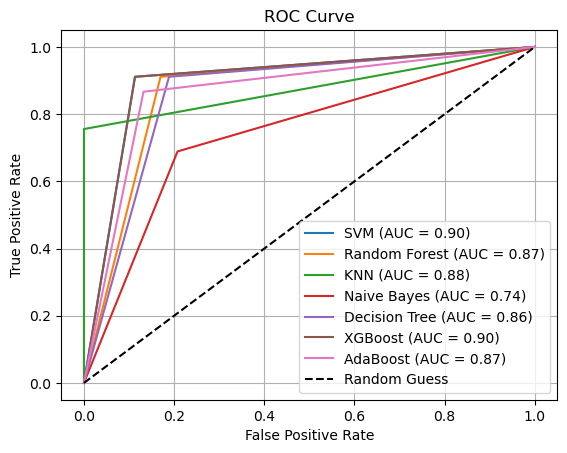

SVM Performance Metrics:
Accuracy: 0.8979591836734694
Precision: 0.8723404255319149
Recall: 0.9111111111111111
F1 Score: 0.891304347826087
AUC-ROC: 0.8989517819706498
Time: 1.6753807067871094

Random Forest Performance Metrics:
Accuracy: 0.8673469387755102
Precision: 0.82
Recall: 0.9111111111111111
F1 Score: 0.8631578947368421
AUC-ROC: 0.870649895178197
Time: 111.54330348968506

KNN Performance Metrics:
Accuracy: 0.8877551020408163
Precision: 1.0
Recall: 0.7555555555555555
F1 Score: 0.8607594936708861
AUC-ROC: 0.8777777777777778
Time: 1.8840904235839844

Naive Bayes Performance Metrics:
Accuracy: 0.7448979591836735
Precision: 0.7380952380952381
Recall: 0.6888888888888889
F1 Score: 0.7126436781609196
AUC-ROC: 0.7406708595387841
Time: 0.25217151641845703

Decision Tree Performance Metrics:
Accuracy: 0.8571428571428571
Precision: 0.803921568627451
Recall: 0.9111111111111111
F1 Score: 0.8541666666666666
AUC-ROC: 0.8612159329140461
Time: 2.7909200191497803

XGBoost Performance Metrics:
Accu

In [19]:
results_female = evaluate_classifiers(X_train_female, y_train_female, X_test_female, y_test_female,'FemaleWithSmoteNormCorr')

for clf_name, metrics in results_female.items():
    print(clf_name + " Performance Metrics:")
    print("Accuracy:", metrics['accuracy'])
    print("Precision:", metrics['precision'])
    print("Recall:", metrics['recall'])
    print("F1 Score:", metrics['f1'])
    print("AUC-ROC:", metrics['auc'])
    print("Time:", metrics['time_execution'])
    print()

Model for SVM saved.
Classification Report for SVM:
              precision    recall  f1-score   support

           0       0.91      0.98      0.95        64
           1       0.98      0.91      0.94        65

    accuracy                           0.95       129
   macro avg       0.95      0.95      0.95       129
weighted avg       0.95      0.95      0.95       129

[[63  1]
 [ 6 59]]
Model for Random Forest saved.
Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        64
           1       1.00      0.95      0.98        65

    accuracy                           0.98       129
   macro avg       0.98      0.98      0.98       129
weighted avg       0.98      0.98      0.98       129

[[64  0]
 [ 3 62]]
Model for KNN saved.
Classification Report for KNN:
              precision    recall  f1-score   support

           0       0.91      1.00      0.96        64
           1       1.00

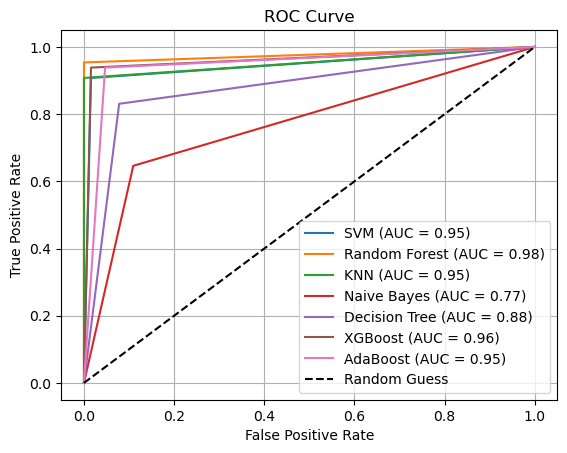

SVM Performance Metrics:
Accuracy: 0.9457364341085271
Precision: 0.9833333333333333
Recall: 0.9076923076923077
F1 Score: 0.944
AUC-ROC: 0.9460336538461538
Time: 2.69638729095459

Random Forest Performance Metrics:
Accuracy: 0.9767441860465116
Precision: 1.0
Recall: 0.9538461538461539
F1 Score: 0.9763779527559054
AUC-ROC: 0.976923076923077
Time: 175.077894449234

KNN Performance Metrics:
Accuracy: 0.9534883720930233
Precision: 1.0
Recall: 0.9076923076923077
F1 Score: 0.9516129032258065
AUC-ROC: 0.9538461538461538
Time: 1.818023681640625

Naive Bayes Performance Metrics:
Accuracy: 0.7674418604651163
Precision: 0.8571428571428571
Recall: 0.6461538461538462
F1 Score: 0.736842105263158
AUC-ROC: 0.768389423076923
Time: 0.2810044288635254

Decision Tree Performance Metrics:
Accuracy: 0.875968992248062
Precision: 0.9152542372881356
Recall: 0.8307692307692308
F1 Score: 0.870967741935484
AUC-ROC: 0.8763221153846155
Time: 4.606791734695435

XGBoost Performance Metrics:
Accuracy: 0.961240310077519

In [26]:
results_male = evaluate_classifiers(X_train_male, y_train_male, X_test_male, y_test_male,'MaleWithSmoteNormCorr')

for clf_name, metrics in results_male.items():
    print(clf_name + " Performance Metrics:")
    print("Accuracy:", metrics['accuracy'])
    print("Precision:", metrics['precision'])
    print("Recall:", metrics['recall'])
    print("F1 Score:", metrics['f1'])
    print("AUC-ROC:", metrics['auc'])
    print("Time:", metrics['time_execution'])
    print()

In [27]:
results_female['KNN']

{'accuracy': 0.8877551020408163,
 'precision': 1.0,
 'recall': 0.7555555555555555,
 'f1': 0.8607594936708861,
 'auc': 0.8777777777777778,
 'time_execution': 1.8840904235839844,
 'best_params': {'n_neighbors': 3, 'p': 1, 'weights': 'distance'}}

In [29]:
results_male['KNN']

{'accuracy': 0.9534883720930233,
 'precision': 1.0,
 'recall': 0.9076923076923077,
 'f1': 0.9516129032258065,
 'auc': 0.9538461538461538,
 'time_execution': 1.818023681640625,
 'best_params': {'n_neighbors': 3, 'p': 1, 'weights': 'distance'}}